## Demo: Optimal Eye Surgeon (OES) pruned network alleviates overfitting and performs better than deep decoder (Approximate run time: 10 mins combined)

### Load the modules

In [23]:
from __future__ import print_function
import matplotlib.pyplot as plt
import os
import glob
import warnings
import numpy as np
from utils.denoising_utils import *
from models import *
from utils.quant import *
from utils.imp import *
from models.cnn import cnn
from PIL import Image
import torch
import torch.optim
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
import pickle as cPickle
#Suppress warnings
warnings.filterwarnings("ignore")

# Enable CUDA
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
dtype = torch.cuda.FloatTensor
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loading the noisy images

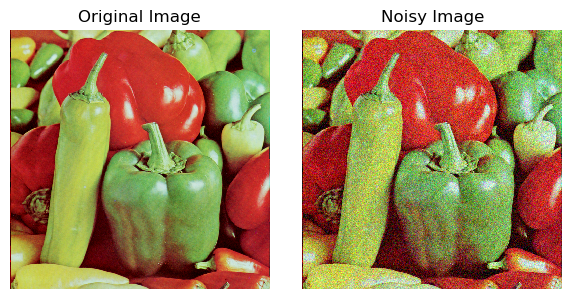

The PSNR of the noisy image is 20.316527224139644


In [7]:
train_folder = 'images'
image_name='pepper'
sigma=0.1
img_np, img_noisy_np, noisy_psnr = load_image(train_folder, image_name, sigma)
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

# Plot original image
axes[0].imshow(img_np.transpose(1, 2, 0))
axes[0].set_title('Original Image')
axes[0].axis('off')  # Optional: to turn off the axis

# Plot noisy image
axes[1].imshow(img_noisy_np.transpose(1, 2, 0))
axes[1].set_title('Noisy Image')
axes[1].axis('off')  # Optional: to turn off the axis

# Display the plots
plt.tight_layout()
plt.show()

print(f"The PSNR of the noisy image is {noisy_psnr}")



### Training dense DIP network

In [8]:
input_depth = 32
output_depth = 3
num_layers = 6

mse = torch.nn.MSELoss().type(dtype)
net_input = get_noise(input_depth, "noise", img_np.shape[1:]).type(dtype)

network = skip(
    input_depth, output_depth,
    num_channels_down=[16, 32, 64, 128, 128, 128][:num_layers],
    num_channels_up=[16, 32, 64, 128, 128, 128][:num_layers],
    num_channels_skip=[0] * num_layers,
    upsample_mode='nearest',
    downsample_mode='avg',
    need1x1_up=False,
    filter_size_down=5,
    filter_size_up=3,
    filter_skip_size=1,
    need_sigmoid=True,
    need_bias=True,
    pad='reflection',
    act_fun='LeakyReLU'
).type(dtype)


psnr_vanilla,out_vanilla = train_dense(network, net_input,  img_np, img_noisy_np,learning_rate=1e-3, 
            max_step=20000, show_every=1000, device='cuda:0')

1.1.1.weight         | nonzeros =   12800 /   12800             (100.00%) | total_pruned =       0 | shape = torch.Size([16, 32, 5, 5])
1.1.1.bias           | nonzeros =      16 /      16             (100.00%) | total_pruned =       0 | shape = torch.Size([16])
1.2.weight           | nonzeros =      16 /      16             (100.00%) | total_pruned =       0 | shape = torch.Size([16])
1.2.bias             | nonzeros =       0 /      16             (  0.00%) | total_pruned =      16 | shape = torch.Size([16])
1.4.1.weight         | nonzeros =    6400 /    6400             (100.00%) | total_pruned =       0 | shape = torch.Size([16, 16, 5, 5])
1.4.1.bias           | nonzeros =      16 /      16             (100.00%) | total_pruned =       0 | shape = torch.Size([16])
1.5.weight           | nonzeros =      16 /      16             (100.00%) | total_pruned =       0 | shape = torch.Size([16])
1.5.bias             | nonzeros =       0 /      16             (  0.00%) | total_pruned =      16

epoch:  1000 loss:  0.00872313417494297 PSNR:  27.68735632774409
epoch:  2000 loss:  0.00704752653837204 PSNR:  25.052311593321853
epoch:  3000 loss:  0.005973609164357185 PSNR:  24.062233964916643
epoch:  4000 loss:  0.005647665821015835 PSNR:  23.500810131998207
epoch:  5000 loss:  0.005027898121625185 PSNR:  23.24992653497082
epoch:  6000 loss:  0.004794779233634472 PSNR:  23.017171794722145
epoch:  7000 loss:  0.0045094662345945835 PSNR:  22.89780193799138
epoch:  8000 loss:  0.004461623728275299 PSNR:  22.652958136335172
epoch:  9000 loss:  0.0042508868500590324 PSNR:  22.666720431746988
epoch:  10000 loss:  0.004316292703151703 PSNR:  22.63145691876566
epoch:  11000 loss:  0.004052915144711733 PSNR:  22.488412754920397
epoch:  12000 loss:  0.004121252801269293 PSNR:  22.521583736910713
epoch:  13000 loss:  0.003981593996286392 PSNR:  22.37290945268315
epoch:  14000 loss:  0.0038745258934795856 PSNR:  22.479780426443693
epoch:  15000 loss:  0.003910013008862734 PSNR:  22.260187157

### Training a deep decoder with k=5 layers

In [9]:
k=5
psnr_decoder,out_decoder= train_deep_decoder(k, img_np, img_noisy_np, max_step=20000, show_every=1000, device='cuda:0')

Number of params in decoder is: 100224
epoch:  0 loss:  0.09201057255268097 PSNR:  10.66773593955106
epoch:  1000 loss:  0.010293973609805107 PSNR:  27.21729214332077
epoch:  2000 loss:  0.0099877854809165 PSNR:  27.377246678709668
epoch:  3000 loss:  0.009815014898777008 PSNR:  27.379367329325785
epoch:  4000 loss:  0.009765904396772385 PSNR:  27.282562353875576
epoch:  5000 loss:  0.009608868509531021 PSNR:  27.28987630162088
epoch:  6000 loss:  0.009649118408560753 PSNR:  27.035285527502523
epoch:  7000 loss:  0.009582607075572014 PSNR:  27.06801162854425
epoch:  8000 loss:  0.00953544583171606 PSNR:  27.052145103090794
epoch:  9000 loss:  0.009480910375714302 PSNR:  26.993819231303284
epoch:  10000 loss:  0.00933242216706276 PSNR:  27.249136704788373
epoch:  11000 loss:  0.009435261599719524 PSNR:  26.93610632655222
epoch:  12000 loss:  0.00932154431939125 PSNR:  27.02757765282692
epoch:  13000 loss:  0.009385641664266586 PSNR:  26.817305021604096
epoch:  14000 loss:  0.00926528405

### Training sparse network with OES mask 

In [10]:
input_depth = 32
output_depth = 3
num_layers = 6

mse = torch.nn.MSELoss().type(dtype)
net_input = get_noise(input_depth, "noise", img_np.shape[1:]).type(dtype)

outdir = f'sparse_models/{image_name}/sparse_0.03'
with open(f'{outdir}/masked_model_0.pkl', 'rb') as f:
    masked_model = cPickle.load(f)
with open(f'{outdir}/net_input_list_0.pkl', 'rb') as f:
    net_input_list = cPickle.load(f)
with open(f'{outdir}/mask_0.pkl', 'rb') as f:
    mask = cPickle.load(f)
    
masked_model = skip(
    input_depth, output_depth,
    num_channels_down=[16, 32, 64, 128, 128, 128][:num_layers],
    num_channels_up=[16, 32, 64, 128, 128, 128][:num_layers],
    num_channels_skip=[0] * num_layers,
    upsample_mode='nearest',
    downsample_mode='avg',
    need1x1_up=False,
    filter_size_down=5,
    filter_size_up=3,
    filter_skip_size=1,
    need_sigmoid=True,
    need_bias=True,
    pad='reflection',
    act_fun='LeakyReLU'
).type(dtype)    
masked_model = mask_network(mask, masked_model) 

psnr_sparse,out_sparse = train_sparse(masked_model, net_input, mask, img_np, img_noisy_np,
            max_step=20000, show_every=1000, device='cuda:0')

1.1.1.weight         | nonzeros =    1029 /   12800             (  8.04%) | total_pruned =   11771 | shape = torch.Size([16, 32, 5, 5])
1.1.1.bias           | nonzeros =       0 /      16             (  0.00%) | total_pruned =      16 | shape = torch.Size([16])
1.2.weight           | nonzeros =       8 /      16             ( 50.00%) | total_pruned =       8 | shape = torch.Size([16])
1.2.bias             | nonzeros =       0 /      16             (  0.00%) | total_pruned =      16 | shape = torch.Size([16])
1.4.1.weight         | nonzeros =     120 /    6400             (  1.88%) | total_pruned =    6280 | shape = torch.Size([16, 16, 5, 5])
1.4.1.bias           | nonzeros =       0 /      16             (  0.00%) | total_pruned =      16 | shape = torch.Size([16])
1.5.weight           | nonzeros =       5 /      16             ( 31.25%) | total_pruned =      11 | shape = torch.Size([16])
1.5.bias             | nonzeros =       0 /      16             (  0.00%) | total_pruned =      16

epoch:  1000 loss:  0.010203538462519646 PSNR:  28.181448042990116 PSNR_noisy:  19.912492027668595
epoch:  2000 loss:  0.009626161307096481 PSNR:  28.838886339957256 PSNR_noisy:  20.165469125150718
epoch:  3000 loss:  0.009424157440662384 PSNR:  28.526183658401514 PSNR_noisy:  20.257574476482144
epoch:  4000 loss:  0.009276021271944046 PSNR:  28.23163534986214 PSNR_noisy:  20.326382802057374
epoch:  5000 loss:  0.009182563982903957 PSNR:  27.983566612964985 PSNR_noisy:  20.37036067458034
epoch:  6000 loss:  0.009034397080540657 PSNR:  27.989998938316305 PSNR_noisy:  20.4410083961538
epoch:  7000 loss:  0.008928212337195873 PSNR:  27.951825750739605 PSNR_noisy:  20.492355066232058
epoch:  8000 loss:  0.008899860084056854 PSNR:  27.83704310744074 PSNR_noisy:  20.5061684352475
epoch:  9000 loss:  0.008861023001372814 PSNR:  27.72200300919674 PSNR_noisy:  20.525161563255274
epoch:  10000 loss:  0.008767387829720974 PSNR:  27.684278161650223 PSNR_noisy:  20.571297907292067
epoch:  11000 los

### Plot the training curves and final reconstructions

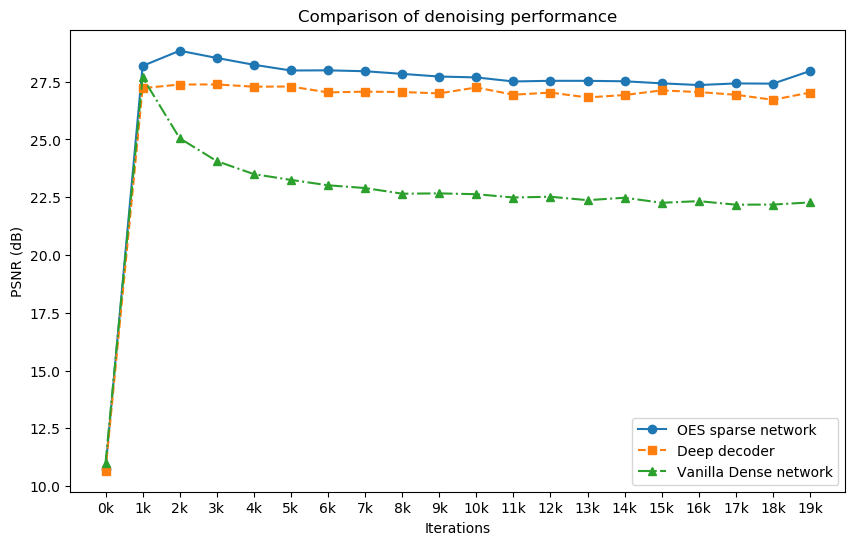

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(psnr_sparse, label='OES sparse network', marker='o', linestyle='-')
plt.plot(psnr_decoder, label='Deep decoder', marker='s', linestyle='--')
plt.plot(psnr_vanilla, label='Vanilla Dense network', marker='^', linestyle='-.')

# Label the axes
plt.xlabel('Iterations')
plt.ylabel('PSNR (dB)')

# Add a title
plt.title('Comparison of denoising performance')


num_iterations = len(psnr_sparse)  
xticks = range(0, num_iterations * 1000, 1000)
xtick_labels = [f'{i // 1000}k' for i in xticks]  
plt.xticks(ticks=range(0, num_iterations), labels=xtick_labels)

# Add a legend
plt.legend()

# Display the plot
plt.show()

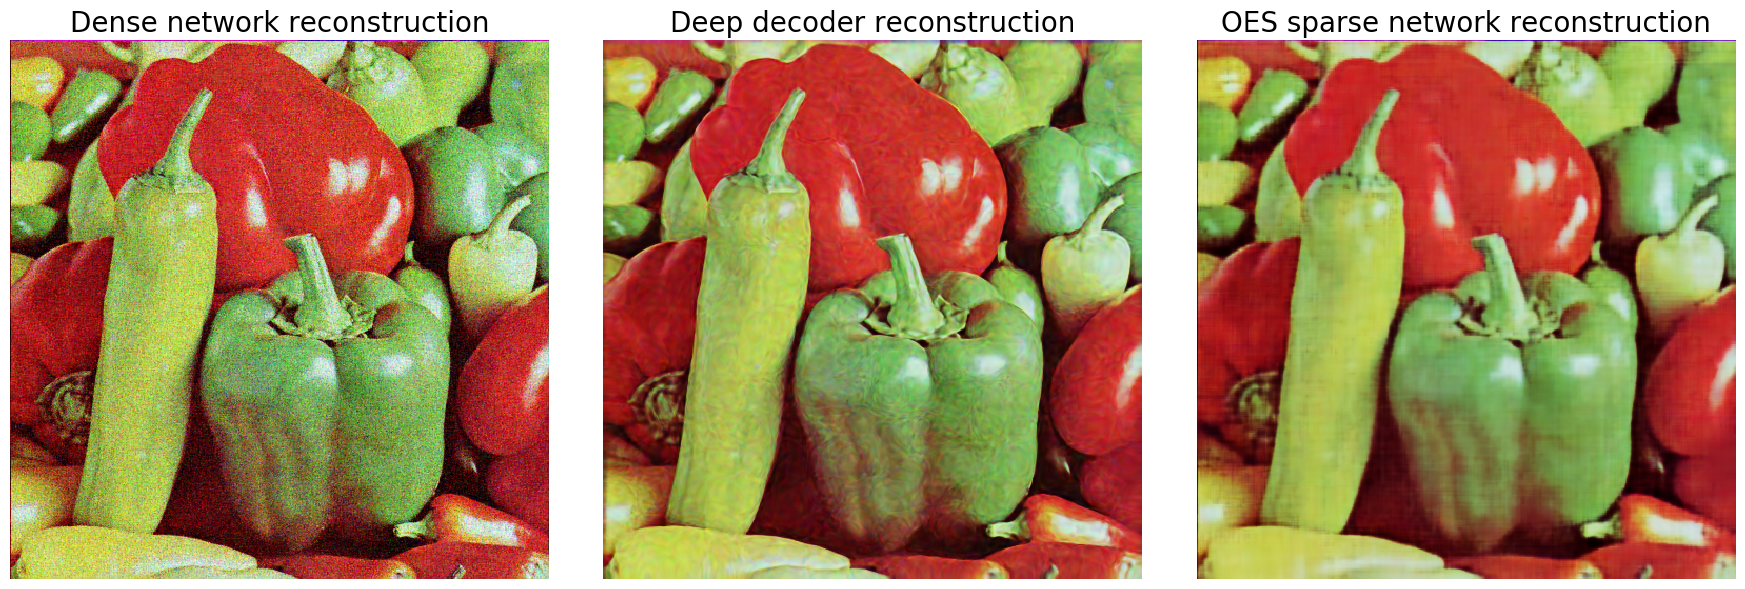

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(18, 18))

# Plot original image
axes[0].imshow(out_vanilla[0,:,:,].transpose(1, 2, 0))
axes[0].set_title('Dense network reconstruction', fontsize=20)
axes[0].axis('off')  # Optional: to turn off the axis

# Plot noisy image
axes[1].imshow(out_decoder[0,:,:,].transpose(1, 2, 0))
axes[1].set_title('Deep decoder reconstruction', fontsize=20)
axes[1].axis('off')  # Optional: to turn off the axis


# Plot noisy image
axes[2].imshow(out_sparse[0,:,:,].transpose(1, 2, 0))
axes[2].set_title('OES sparse network reconstruction', fontsize=20)
axes[2].axis('off')  # Optional: to turn off the axis


# Display the plots
plt.tight_layout()
plt.show()



### We observe the following features for each network reconstruction:
#### 1) Dense network: Overfits to noise
#### 2) Deep decoder: Has low frequency artifacts due to downsampling layers. 
#### 3) OES masked network: Performs good reconstruction without overfitting to noise and having comparable parameters as decoder. 